In [1]:
import nibabel as nib
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import tifffile
from PIL import Image
from skimage import io
import os
import pandas as pd
from typing import Tuple, Optional, List, Dict, Callable
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv3D, Conv3DTranspose,MaxPooling3D, concatenate,UpSampling3D,Dropout

### Functions

In [2]:
def show_slices(slices: List):
    """
    Function to display a row of image slices
    
    Params
    ------
    slices: List
        List of numpy 2D image slices
    
    Returns
    -------
    
    """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

def show_mid_slice(img_numpy):
    """
    Accepts an 3D numpy array and shows median slices in all three planes
    
    Params
    ------
    img_numpy : np.array
        3D numpy array containing the image data
        
    returns
    -------
    
    """
    assert img_numpy.ndim == 3, "please provide a 3d numpy image"
    n_i, n_j, n_k = img_numpy.shape

    # saggital
    center_i1 = int((n_i - 1) / 2)
    # transversecreate_2d_views
    center_j1 = int((n_j - 1) / 2)
    # axial slice
    center_k1 = int((n_k - 1) / 2)
    
    show_slices([img_numpy[center_i1, :, :],
                 img_numpy[:, center_j1, :],
                 img_numpy[:, :, center_k1]])

def img_dataset(df_inp,path_img,path_mask,args,batch):
    """
    Function to create image datasets using keras flow_from_dataframe
    
    Params
    ------
    df_inp: pd.DataFrame
        pd.DataFrame containing paths to images and labels
    
    path_img: str
        Name of the column where image paths are
    
    path_mask: str
        Name of the column where label paths are
    
    batch: int
        Batch size
    
    Returns
    -------
    data_gen: zip 
        Images zipped to masks
    """
    img_gen=ImageDataGenerator(rescale=1/255,**args)
    df_img = img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=path_img,
                                     class_mode=None,
                                     batch_size=batch,
                                    color_mode='grayscale',
                                         seed=1,
                                     target_size=(256,256,256))
    df_mask=img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=path_mask,
                                     class_mode=None,
                                     batch_size=batch,
                                    color_mode='grayscale',
                                        seed=1,
                                     target_size=(256,256,256))
    data_gen = zip(df_img,df_mask)
    return data_gen


def dice_loss(y_true, y_pred):
    """
    Functions to create dice_loss metric
    
    Params
    ------
    y_true: float
        Real output
    
    y_pred: float
        Predicted output
        
    Return
    ------
    diceloss: float
        diceloss metric
    """
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersec=K.sum(y_true* y_pred)
    diceloss = (-((2* intersec + 0.1) / (K.sum(y_true) + K.sum(y_pred) + 0.1)))
    return diceloss

def iou(y_true,y_pred):
    """
    Functions to create dice_loss iou
    
    Params
    ------
    y_true: float
        Real output
    
    y_pred: float
        Predicted output
        
    Return
    ------
    iou: float
        iou metric
    """
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersec + 0.1) / (union- intersec + 0.1)
    return iou

def conv_block(inp,filters):
    """
    Creates convolutional block of the networks
    
    Params
    ------
    inp: input to the block
    
    Filters: number of filters of the block
    
    Returns
    -------
    x: Convolutional Block
    """
    x=Conv3D(filters,(3,3,3),padding='same',activation='relu')(inp)
    x=Conv3D(filters,(3,3,3),padding='same')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    return x

def encoder_block(inp,filters):
    """
    Creates encoder block of the networks
    
    Params
    ------
    inp: input to the block
    
    Filters: number of filters of the block
    
    Returns
    -------
    x: convolutional Block
    p: 2x2x2 Pooling 
    """
    x=conv_block(inp,filters)
    p=MaxPooling3D(pool_size=(2,2,2))(x)
    return x,p

def attention_block(l_layer,h_layer): #Attention Block
    phi=Conv3D(h_layer.shape[-1],(1,1,1),padding='same')(l_layer)
    theta=Conv3D(h_layer.shape[-1],(1,1,1),strides=(2,2,2),padding='same')(h_layer)
    x=tf.keras.layers.add([phi,theta])
    x=Activation('relu')(x)
    x=Conv3D(1,(1,1,1),padding='same',activation='sigmoid')(x)
    x=UpSampling3D(size=(2,2,2))(x)
    x=tf.keras.layers.multiply([h_layer,x])
    x=BatchNormalization(axis=3)(x)
    return x
    
def decoder_block(inp,filters,concat_layer):
    """
    Creates the decoder block of the network
    
    Params
    ------
    inp: input to the block
    
    Filters: number of filters of the block
    
    concat_layer: Layer to concat convolution of the input with
    
    Returns
    -------
    x: convolutional Block
    p: 2x2x2 Pooling 
    """
    x=Conv3DTranspose(filters,(2,2,2),strides=(2,2,2),padding='same')(inp)
    concat_layer=attention_block(inp,concat_layer)
    x=concatenate([x,concat_layer])
    x=conv_block(x,filters)
    return x

### EDA

In [3]:
###### Run to convert img files to tiff files
###### This is needed because the keras function flow_from dataframe cannot read from .img files
directory = "./iSeg-2019-Training/"
images = [file for file in os.listdir(directory) if file[-3:] == "img"]
for image in images: 
    if "label" not in image:
        img = nib.load(directory + image)
        array_img = np.asanyarray(img.dataobj)
        tifffile.imsave("./Training/{}.tif".format(image[:-4]),array_img)
    else:
        img = nib.load(directory + image)
        array_img = np.asanyarray(img.dataobj)
        tifffile.imsave("./Training_labels/{}.tif".format(image[:-4]),array_img)

La dimension de las imágenes es: (144, 192, 256, 1)
La dimension de las imágenes es: (144, 192, 256, 1)
Sección 2D de la imagen:


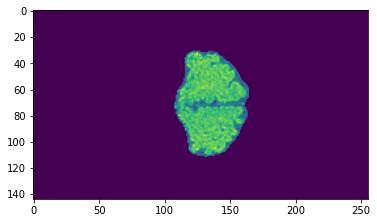

Sección 2D de la imagen:


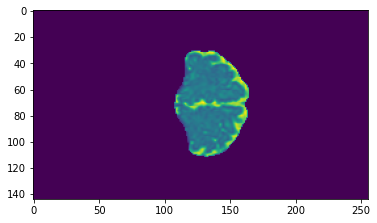

Misma sección 2D de la etiqueta:


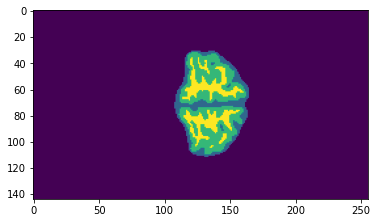

In [4]:
## Manual image read with nibabel library
img_label = nib.load('./iSeg-2019-Training/subject-3-label.img')

img = nib.load('./iSeg-2019-Training/subject-3-T1.img')

img2 = nib.load('./iSeg-2019-Training/subject-3-T2.img')

print("La dimension de las imágenes es: {}".format(np.asanyarray(img.dataobj).shape)) ##Image size

print("La dimension de las imágenes es: {}".format(np.asanyarray(img_label.dataobj).shape)) #Label image size

print("Sección 2D de la imagen:")
plt.imshow(np.asanyarray(img.dataobj)[:,50,:])
plt.show() ## Show T1 image

print("Sección 2D de la imagen:")
plt.imshow(np.asanyarray(img2.dataobj)[:,50,:])
plt.show() ## Show T2 image

print("Misma sección 2D de la etiqueta:")
plt.imshow(np.asanyarray(img_label.dataobj)[:,50,:]) ## Show label

Sección 2D de la imagen:


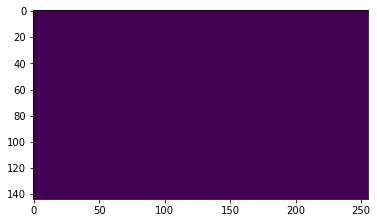

Sección 2D de la imagen:


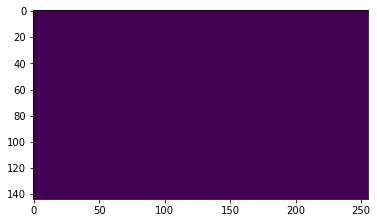

Misma sección 2D de la etiqueta:


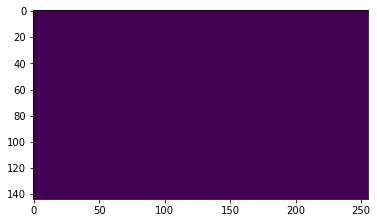

In [5]:
#We can see that borders are fully background
print("Sección 2D de la imagen:")
plt.imshow(np.asanyarray(img.dataobj)[:,0,:])
plt.show() ## Show T1 image

print("Sección 2D de la imagen:")
plt.imshow(np.asanyarray(img2.dataobj)[:,0,:])
plt.show() ## Show T2 image

print("Misma sección 2D de la etiqueta:")
plt.imshow(np.asanyarray(img_label.dataobj)[:,0,:]) ## Show label

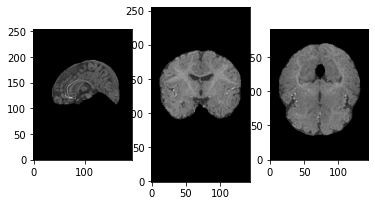

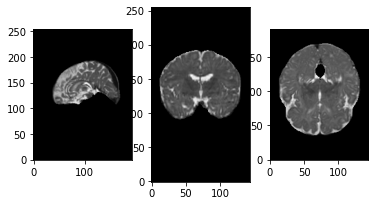

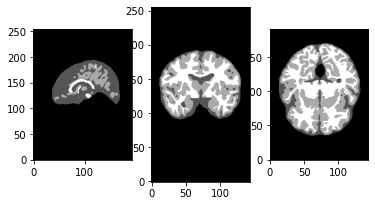

In [6]:
# Show middle slides of the image (T1 and T2) and its label
for i in [img,img2,img_label]:
    i = i.get_fdata()[:,:,:,0]
    show_mid_slice(i)

In [7]:
## Build the DataFrame with the images path
actual_dir = os.getcwd()

training_img = []
training_labels_img = []
for i in os.listdir(actual_dir+"/Training"):
    img_directory = "./Training/" + i
    if i.startswith("subject"):
        training_img.append(img_directory)
for i in os.listdir(actual_dir+"/Training_labels"):
    img_directory = "./Training_labels/" + i
    if i.startswith("subject"):
        training_labels_img.append(img_directory)

rows = []
for label in training_labels_img:
    for training in training_img:

        if training.split("-")[1] == label.split("-")[1]:
            row = (label,training)
        rows.append(row)
rows = list(set(rows))

df_directories = pd.DataFrame(rows).rename(columns = {0 : "Label",1:"Image"})

In [8]:
df_directories

,Label,Image
0,./Training_labels/subject-3-label.tif,./Training/subject-3-T2.tif
1,./Training_labels/subject-6-label.tif,./Training/subject-6-T1.tif
2,./Training_labels/subject-5-label.tif,./Training/subject-5-T1.tif
3,./Training_labels/subject-9-label.tif,./Training/subject-9-T1.tif
4,./Training_labels/subject-4-label.tif,./Training/subject-4-T2.tif
5,./Training_labels/subject-2-label.tif,./Training/subject-2-T1.tif
6,./Training_labels/subject-10-label.tif,./Training/subject-10-T1.tif
7,./Training_labels/subject-2-label.tif,./Training/subject-2-T2.tif
8,./Training_labels/subject-9-label.tif,./Training/subject-9-T2.tif
9,./Training_labels/subject-6-label.tif,./Training/subject-6-T2.tif


## Build the model 

In [9]:
inputs=Input((256,256,256,1))
d1,p1=encoder_block(inputs,64)
d2,p2=encoder_block(p1,128)
d3,p3=encoder_block(p2,256)
d4,p4=encoder_block(p3,512)
b1=conv_block(p4,1024)
e2=decoder_block(b1,512,d4)
e3=decoder_block(e2,256,d3)
e4=decoder_block(e3,128,d2)
e5=decoder_block(e4,64,d1)
outputs = Conv3D(1, (1,1,1),activation="sigmoid")(e5)
model=Model(inputs=[inputs], outputs=[outputs],name='AttnetionUnet')

In [10]:
model.summary()

Model: "AttnetionUnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 25 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 256, 256, 256 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, 256 110656      conv3d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 256 1024        conv3d_1[0][0]                   
______________________________________________________________________________________

In [11]:
augmentation_args=dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            fill_mode='nearest')
batch=1

In [12]:
train_set, val_set = train_test_split(df_directories, test_size=0.2)

In [13]:
train_set.reset_index(inplace = True)
val_set.reset_index(inplace = True)

In [14]:
def train_model(model,save_name,loss_func):
    opt = Adam(learning_rate=1e-4, epsilon=None, amsgrad=False,beta_1=0.9,beta_2=0.99)
    model.compile(optimizer=opt, loss=loss_func,metrics=[iou])
    callbacks = [ModelCheckpoint(save_name,verbose=4,save_best_only=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=4,patience=5, min_lr=1e-6),
                EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]
    train=img_dataset(train_set,'Image','Label',augmentation_args,batch)
    val=img_dataset(val_set,'Image','Label',dict(),batch)

    history = model.fit(train, 
                                  validation_data=val,
                                  steps_per_epoch=int(len(train_set)/batch), 
                                  validation_steps=int(len(val_set)/batch), 
                                  epochs = 25,
                                 callbacks=callbacks)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Training Loss Curve")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [15]:
train=img_dataset(train_set,'Image','Label',augmentation_args,batch)

Found 16 validated image filenames.
Found 16 validated image filenames.


In [ ]:
train_model(model,'unet_wts1.hdf5',dice_loss)

Found 16 validated image filenames.
Found 16 validated image filenames.
Found 4 validated image filenames.
Found 4 validated image filenames.
Epoch 1/25
